In [ ]:
!pip install --upgrade transformers datasets evaluate

In [ ]:
import pandas as pd
from datasets import load_dataset


dataset = load_dataset("tweet_eval", "sentiment")

df = pd.DataFrame(dataset['train'])




print(df.head())
print("\n" + "="*50 + "\n")

df.info()
print("\n" + "="*50 + "\n")

sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['sentiment_label'] = df['label'].map(sentiment_labels)


print(df['sentiment_label'].value_counts())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--- First 5 Rows of the Dataset ---
                                                text  label
0  "QT @user In the original draft of the 7th boo...      2
1  "Ben Smith / Smith (concussion) remains out of...      1
2  Sorry bout the stream last night I crashed out...      1
3  Chase Headley's RBI double in the 8th inning o...      1
4  @user Alciato: Bee will invest 150 million in ...      2


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45615 entries, 0 to 45614
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    45615 non-null  object
 1   label   45615 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 712.9+ KB


--- Sentiment Distribution ---
sentiment_label
Neutral     20673
Positive    17849
Negative     7093
Name: count, dtype: int64


In [ ]:


from transformers import AutoTokenizer, AutoModelForSequenceClassification


model_name = "distilbert-base-uncased"


tokenizer = AutoTokenizer.from_pretrained(model_name)


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

from datasets import load_dataset
dataset = load_dataset("tweet_eval", "sentiment")


def tokenize_function(examples):
  """
  This function takes a batch of examples and tokenizes the text.
  - padding="max_length": Pads shorter sentences to the maximum length.
  - truncation=True: Truncates longer sentences to the maximum length.
  """
  return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)


print("--- Original Tweet ---")
print(tokenized_datasets["train"][0]["text"])
print("\n--- Tokenized Input IDs ---")
print(tokenized_datasets["train"][0]["input_ids"])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

--- Original Tweet ---
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"

--- Tokenized Input IDs ---
[101, 1000, 1053, 2102, 1030, 5310, 1999, 1996, 2434, 4433, 1997, 1996, 5504, 2338, 1010, 2128, 7606, 11320, 8091, 5175, 1996, 2645, 1997, 27589, 18367, 2015, 1012, 1001, 3407, 17706, 2705, 10259, 28578, 2271, 7630, 8091, 1000, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# Disable Weights and Biases logging
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import numpy as np
import evaluate
from transformers import Trainer, TrainingArguments


metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)


train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)


trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.609600,0.640816,0.708500
2,0.478700,0.621355,0.737500
3,0.240700,0.867601,0.732500


TrainOutput(global_step=8553, training_loss=0.4728466103289624, metrics={'train_runtime': 6083.9703, 'train_samples_per_second': 22.493, 'train_steps_per_second': 1.406, 'total_flos': 1.812782444732928e+16, 'train_loss': 0.4728466103289624, 'epoch': 3.0})

In [ ]:

test_dataset = tokenized_datasets["test"]
evaluation_results = trainer.evaluate(eval_dataset=test_dataset)

print(evaluation_results)

--- Final Test Set Performance ---
{'eval_loss': 0.7228448390960693, 'eval_accuracy': 0.6908173233474438, 'eval_runtime': 183.8206, 'eval_samples_per_second': 66.826, 'eval_steps_per_second': 1.044, 'epoch': 3.0}


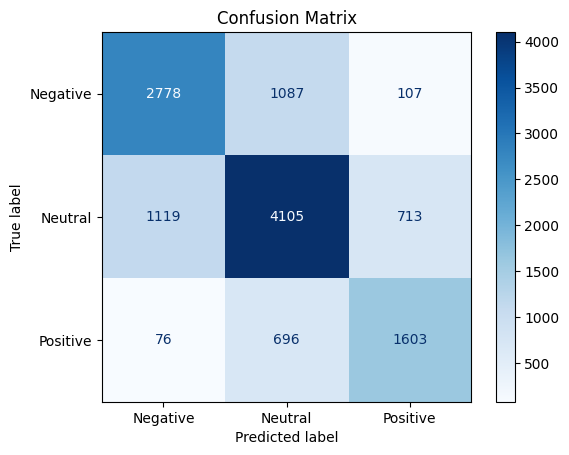


--- Top 10 Misclassified Examples ---
                                                                                                                                            text  \
0                                               @user @user what do these '1/2 naked pics' have to do with anything? They're not even like that.   
3                                                            I think I may be finally in with the in crowd #mannequinchallenge  #grads2014 @user   
5                                        Savchenko now Saakashvili took drug test live on Ukraine TV. To prove they are not drug-fueled loonies?   
13  When Ryan privatizes SS, Medicare, Medicaid, & does away with ACA, what will Trump's base feel about "change" then? That's a big one right?!   
14                                                        Swampbitch Nasty Pelosi  loves yelling 'Fire' in the crowded swamp. #blackfriday @user   
17                                                          ISIS and The 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions_output = trainer.predict(test_dataset)
y_preds = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids


sentiment_labels = ['Negative', 'Neutral', 'Positive']


cm = confusion_matrix(y_true, y_preds, labels=np.arange(len(sentiment_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiment_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


results_df = pd.DataFrame({
    'text': test_dataset['text'],
    'true_label_id': y_true,
    'predicted_label_id': y_preds
})


label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
results_df['true_label_name'] = results_df['true_label_id'].map(label_map)
results_df['predicted_label_name'] = results_df['predicted_label_id'].map(label_map)


misclassified_df = results_df[results_df['true_label_id'] != results_df['predicted_label_id']]


print("\n--- Top 10 Misclassified Examples ---")
pd.set_option('display.max_colwidth', None) # Display full tweet text
print(misclassified_df.head(10)[['text', 'true_label_name', 'predicted_label_name']])

In [ ]:
import torch
import torch.nn.functional as F

# It's a good practice to put the model in "evaluation mode"
# This disables dropout layers and other training-specific parts.
model.eval()

# Define the sentiment labels in the correct order
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Set the device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Make sure the model is on the correct device

def predict_sentiment(text):
    """
    Predicts the sentiment of a single sentence.

    Args:
        text (str): The input sentence.

    Returns:
        dict: A dictionary containing the predicted label and confidence scores.
    """
    # 1. Tokenize the input text
    # return_tensors='pt' tells the tokenizer to return PyTorch tensors
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # 2. Move tensors to the same device as the model
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # 3. Get predictions from the model
    # torch.no_grad() tells PyTorch not to calculate gradients, saving memory and speeding up inference
    with torch.no_grad():
        outputs = model(**inputs)

    # 4. Process the output
    logits = outputs.logits
    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(logits, dim=-1)
    # Get the predicted class index by finding the highest probability
    predicted_class_idx = torch.argmax(probabilities, dim=-1).item()

    # 5. Map the index to its label
    predicted_label = sentiment_labels[predicted_class_idx]

    # Create a dictionary of confidence scores for all labels
    confidence_scores = {label: prob.item() for label, prob in zip(sentiment_labels, probabilities[0])}

    return {
        "predicted_label": predicted_label,
        "confidence_scores": confidence_scores
    }

In [ ]:
# Get input from the user
user_sentence = input("Please enter a sentence to analyze its sentiment: ")

# Check if the user entered something
if user_sentence:
    # Use the function to get the prediction
    prediction = predict_sentiment(user_sentence)

    # Print the results in a user-friendly way
    print("\n--- Analysis Result ---")
    print(f"Sentence: '{user_sentence}'")
    print(f"Predicted Sentiment: {prediction['predicted_label']}")

    # Optional: Print the detailed confidence scores
    # print(f"Confidence Scores: {prediction['confidence_scores']}")
else:
    print("No sentence entered. Please try again.")

Please enter a sentence to analyze its sentiment: the service here is good

--- Analysis Result ---
Sentence: 'the service here is good'
Predicted Sentiment: Positive


In [ ]:

save_directory = "/content/my_sentiment_model"


trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to /content/my_sentiment_model


In [ ]:
import shutil
from google.colab import files

# The path to the folder you want to zip
folder_to_zip = '/content/my_sentiment_model'

# The name of the output zip file
output_filename = 'my_sentiment_model.zip'

# Create the zip archive
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

# Trigger the download of the zip file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>